<center>

*******************************************************************************************

### Kuramoto *r*

##### 1 May 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* The Kuramoto order parameter *r* measures phase coherence (closeness) amongst two or more oscillators.
>
* Tested with:
    * Python 3.11
    * Windows 11
>
* References:
    * Strogatz, S. H. (2000). From Kuramoto to Crawford: exploring the onset of synchronization in populations of coupled oscillators. *Physica D: Nonlinear Phenomena, 143*(1-4), 1-20.
    * https://github.com/fabridamicelli/kuramoto
>
* Instructions:
    * Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys
import numpy as np

sys.path.append('../src')
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


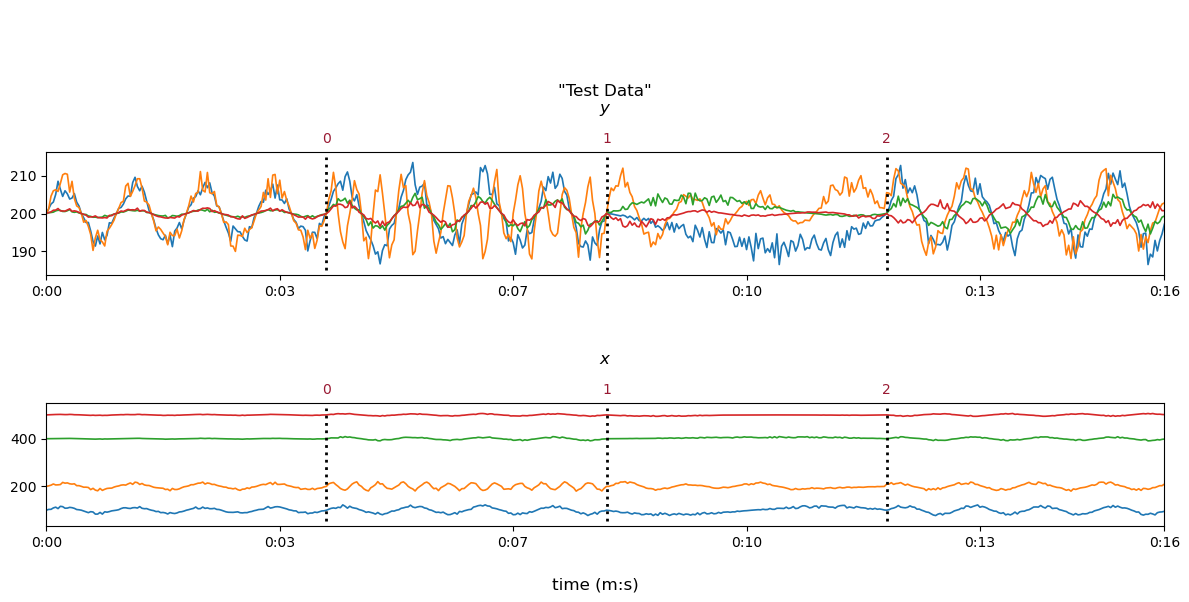

In [2]:
position = sc.ptdata.load( 'make', print_info=True )
position.visualise( vscale=1.2, dlattr='1.2' )

***
### Multiband Kuramoto Order Parameter *r*

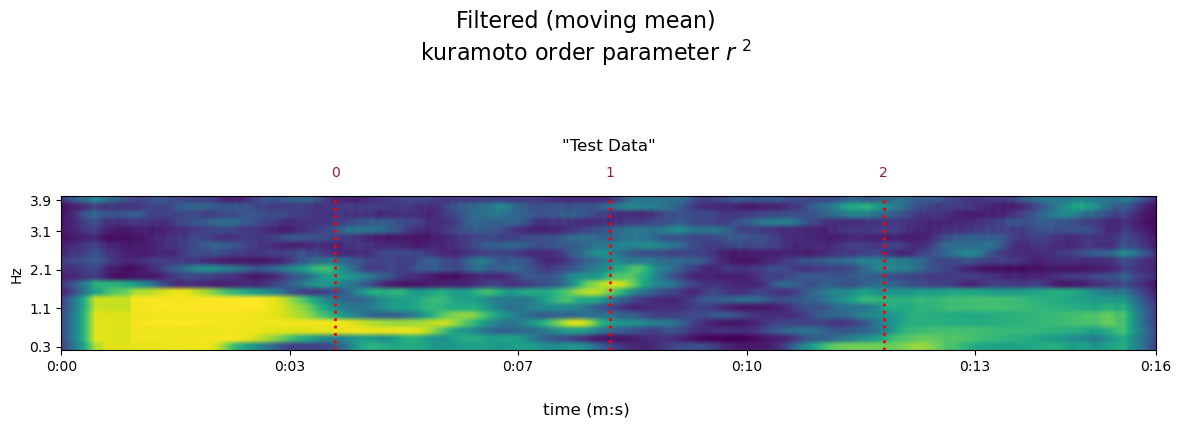

In [3]:

filter_type = 'butter'                    # <---
filter_freq_response = 'bandpass'         # <---
filter_cutoff_freq = np.arange(0.1,4,0.2) # <---
filter_bandwidth = 1                      # <---
filter_order = 3                          # <---
smooth_power = True                       # <---

filtered = sc.ptdata.smooth( position, filter_type=filter_type,
                             freq_response=filter_freq_response,
                             bandwidth=filter_bandwidth,
                             cutoff_freq=filter_cutoff_freq, order=filter_order )

speed = sc.ptdata.tder2D( filtered )
pks_phase = sc.ptdata.peaks_to_phase( speed )
kr_1 = sc.ptdata.kuramoto_r( pks_phase )
kr_2 = kr_1
if smooth_power:
    kr_s = sc.ptdata.smooth( kr_1, filter_type='mean', window_size=1 )
    kr_sp = sc.ptdata.apply( kr_s, np.power, 2 )
    kr_2 = kr_sp
kr_2.visualise( vscale=1.5 )

>
#### Average for group

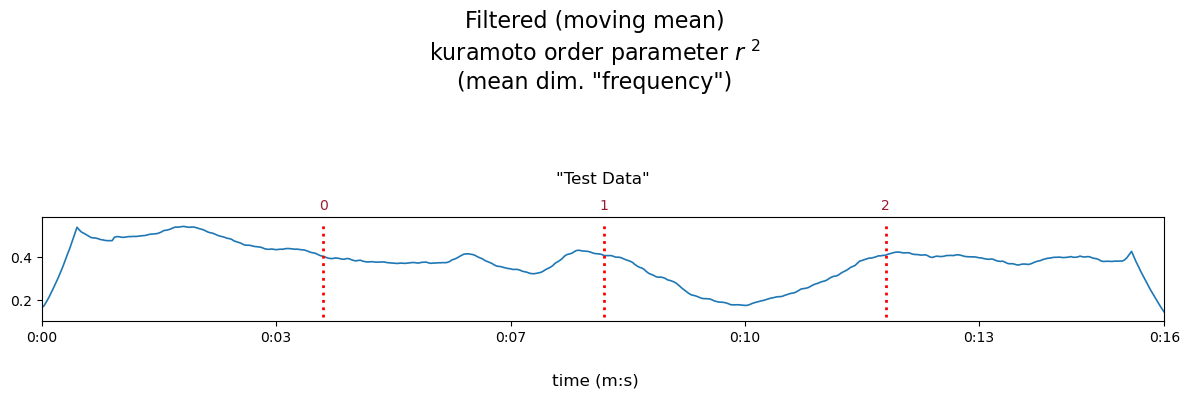

In [4]:
kr_aggr_top = sc.ptdata.aggrax( kr_2, axis=0, function='mean' )
kr_aggr_top.visualise( vscale=1.3, vistype='line', dlattr='1.2' )

>
#### Sections' statistics

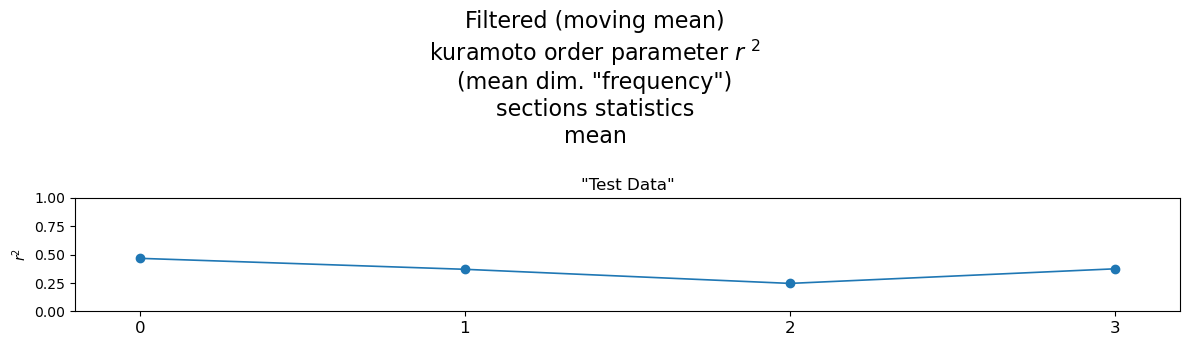

In [7]:

sec_margins = [[0,0.5],[0.5,0.5],[0.5,0.5],[0.5,0]] # <--- sections' margins (seconds)

kr_aggr_top_stats = sc.ptdata.secstats( kr_aggr_top, margins=sec_margins, last=True )
kr_aggr_top_stats.visualise( statistics='mean' )

import matplotlib.pyplot as plt
plt.ylim((0,1))
plt.xlim((-0.2,3.2))
plt.xticks((0,1,2,3),('0','1','2','3'),fontsize=12);